# Amazon Alexa Review - Sentiment Analysis
Examining the Amazon Alexa dataset and developing classification models to determine whether the sentiment of a given input sentence is positive or negative..

## Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\su1qt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Exploratory Data Analysis

In [5]:
# Loading the data

amazon_data = pd.read_csv('amazon_alexa.tsv', delimiter = '\t', quoting = 3)

In [6]:
amazon_data.shape

(3150, 5)

In [7]:
amazon_data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [8]:
# Checking column names
amazon_data.columns

Index(['rating', 'date', 'variation', 'verified_reviews', 'feedback'], dtype='object')

In [9]:
# Checking for any null values
amazon_data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [10]:
# Checking the row for the only null value in the column verigied_reviews
amazon_data[amazon_data['verified_reviews'].isna() == True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [11]:
# Dropping that record

amazon_data.dropna(inplace = True)

In [12]:
#Creating a new column 'length' that will contain the length of the string in 'verified_reviews' column

amazon_data['length'] = amazon_data['verified_reviews'].apply(len)

In [13]:
amazon_data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [14]:
#Randomly checking for 10th record
print(amazon_data.iloc[10]['verified_reviews'])
print(len(amazon_data.iloc[10]['verified_reviews']))
print(amazon_data.iloc[10]['length'])

"I sent it to my 85 year old Dad, and he talks to it constantly."
65
65


We can observe that the review length matches the value in the length column for that entry.

#### Checking Datatypes 

In [17]:
amazon_data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

- rating, feedback and length are integer values
- date, variation and verified_reviews are string values

## Analyzing rating column
This column refers to the rating of the variation given by the user

In [20]:
amazon_data['rating'].value_counts()

rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64

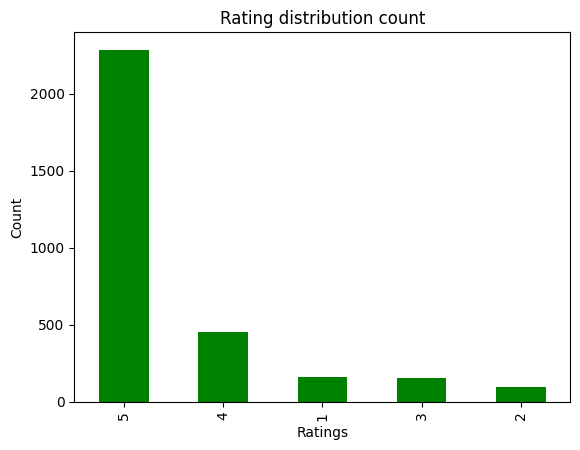

In [21]:
#Bar plot to visualize the total counts of each rating

amazon_data['rating'].value_counts().plot.bar(color = 'green')
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

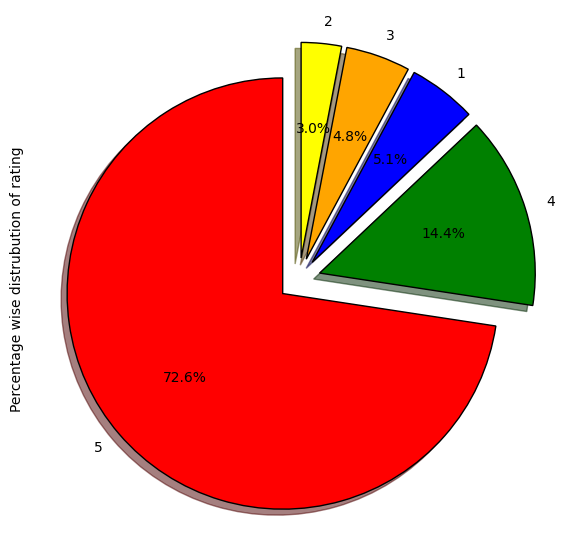

In [22]:
# Plotting the pie chart for % distribution of rating
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green', 'blue','orange','yellow')

wp = {'linewidth':1, "edgecolor":'black'}

tags = amazon_data['rating'].value_counts()/amazon_data.shape[0]

explode=(0.1,0.1,0.1,0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of rating')

from io import  BytesIO

graph = BytesIO()

fig.savefig(graph, format="png")

## Analyzing Feedback Column
This column refers to the feedback of the verified review

In [24]:
amazon_data['feedback'].value_counts()

feedback
1    2893
0     256
Name: count, dtype: int64

There are 2 distinct values of 'feedback' present - 0 and 1. Let's see what kind of review each value corresponds to.

 #### For feedback = 0

In [27]:
#Extracting  verified_reviews' value for some record with feedback = 0

review_0 = amazon_data[amazon_data['feedback'] == 0].iloc[1:3]['verified_reviews']
review_0

111    Sound is terrible if u want good music too get...
141                                   Not much features.
Name: verified_reviews, dtype: object

#### For feedback = 1

In [29]:
#Extracting some 'verified_reviews' value for some record with feedback = 1

review_1 = amazon_data[amazon_data['feedback'] == 1].iloc[1:3]['verified_reviews']
review_1

1                                            Loved it!
2    "Sometimes while playing a game, you can answe...
Name: verified_reviews, dtype: object

From the above 2 examples we can see that feedback __0 is negative review__ and __1 is positive review__

Let's plot the feedback value count in a bar graph

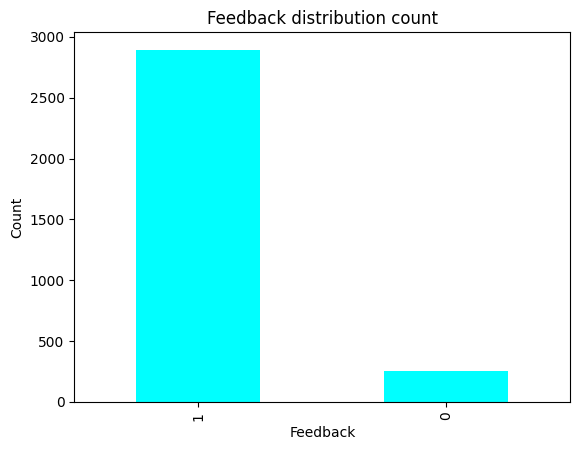

In [31]:
#Bar graph to visualize the total counts of each feedback

amazon_data['feedback'].value_counts().plot.bar(color = 'cyan')
plt.title('Feedback distribution count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

<Axes: ylabel='Percentage wise distrubution of feedback'>

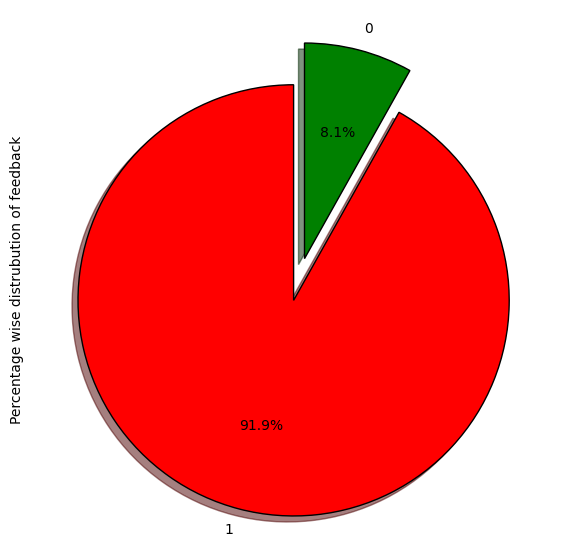

In [32]:
# Plotting the pie chart for % distribution of feedback

fig = plt.figure(figsize=(7,7))

colors = ('red', 'green')

wp = {'linewidth':1, "edgecolor":'black'}

tags = amazon_data['feedback'].value_counts()/amazon_data.shape[0]

explode=(0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of feedback')

#### Seeing the rating values for different values of feedback

In [34]:
# for feedback = 0
amazon_data[amazon_data['feedback'] == 0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

In [35]:
# for feedback = 1
amazon_data[amazon_data['feedback'] == 1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

- Ratings of 1 or 2 correspond to a feedback label of 0 (negative).
- Ratings of 3, 4, or 5 correspond to a feedback label of 1 (positive).

## Analyzing variation column
This column refers to the variation or type of Amazon Alexa product. Example - Black Dot, Charcoal Fabric etc.


In [38]:
amazon_data['variation'].value_counts()

variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64

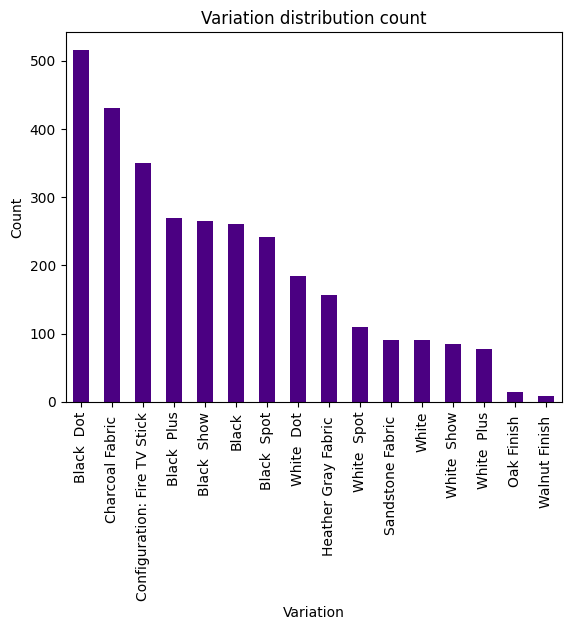

In [39]:
#Bar graph to visualize the total counts of each variation
amazon_data['variation'].value_counts().plot.bar(color = "indigo")
plt.title('Variation distribution count')
plt.xlabel('Variation')
plt.ylabel('Count')
plt.show()

__Mean rating according to variation__

In [41]:
amazon_data.groupby('variation')['rating'].mean()

variation
Black                           4.233716
Black  Dot                      4.453488
Black  Plus                     4.370370
Black  Show                     4.490566
Black  Spot                     4.311203
Charcoal Fabric                 4.730233
Configuration: Fire TV Stick    4.591429
Heather Gray Fabric             4.694268
Oak Finish                      4.857143
Sandstone Fabric                4.355556
Walnut Finish                   4.888889
White                           4.166667
White  Dot                      4.423913
White  Plus                     4.358974
White  Show                     4.282353
White  Spot                     4.311927
Name: rating, dtype: float64

__Analysing the rating__

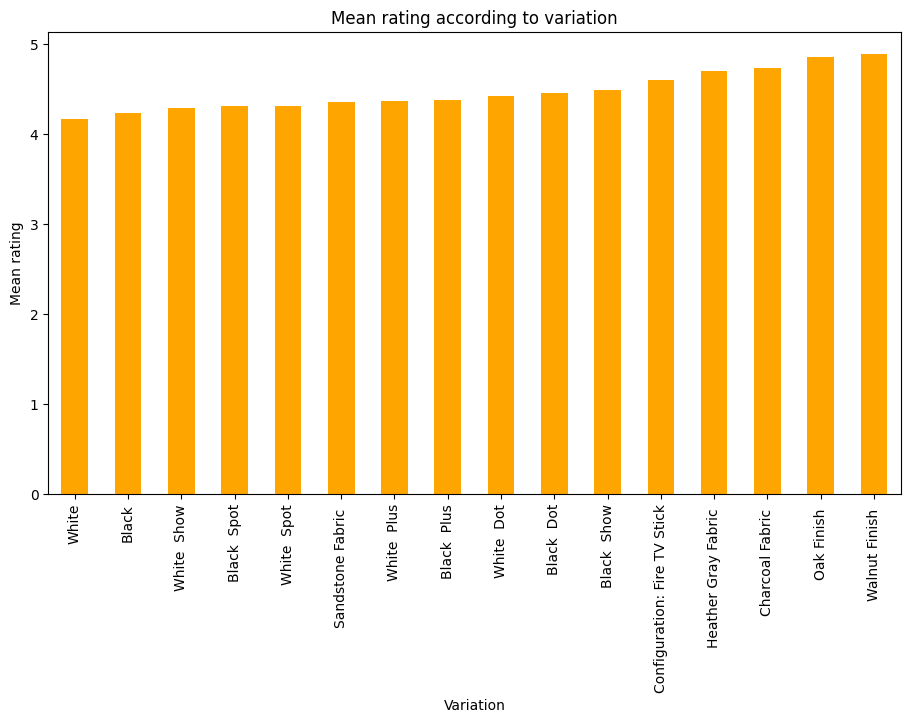

In [43]:
amazon_data.groupby('variation')['rating'].mean().sort_values().plot.bar(color = 'orange', figsize=(11, 6))
plt.title("Mean rating according to variation")
plt.xlabel('Variation')
plt.ylabel('Mean rating')
plt.show()

## Analyzing verified_reviews column
This column contains the textual review given by the user for a variation for the product.

In [45]:
amazon_data['length'].describe()

count    3149.000000
mean      132.714513
std       182.541531
min         1.000000
25%        30.000000
50%        74.000000
75%       166.000000
max      2853.000000
Name: length, dtype: float64

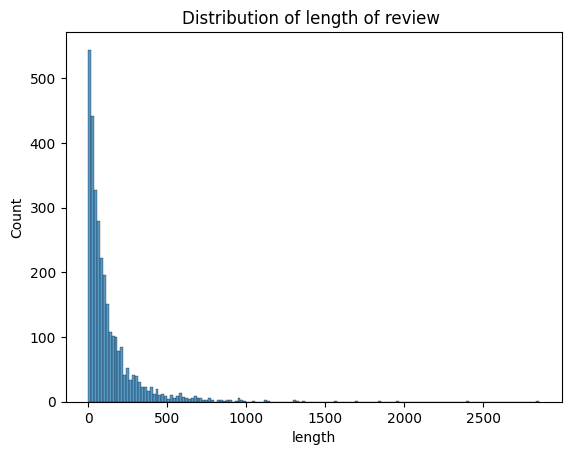

In [46]:
# Plot for length analysis for the whole data set
sns.histplot(amazon_data['length']).set(title='Distribution of length of review ')
plt.show()

__Length Analysis when feedback = 0__

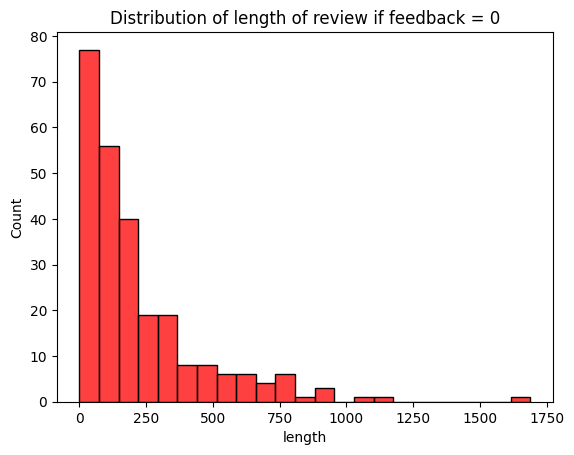

In [48]:
sns.histplot(amazon_data[amazon_data['feedback']==0]['length'],color='red').set(title='Distribution of length of review if feedback = 0')
plt.show()

__Length Analysis when feedback = 1__

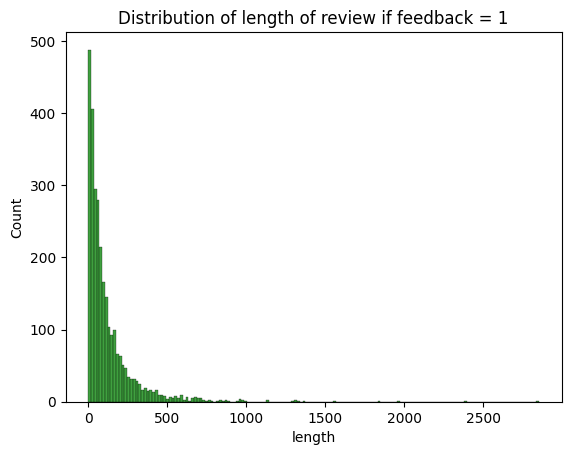

In [50]:
sns.histplot(amazon_data[amazon_data['feedback']==1]['length'],color='green').set(title='Distribution of length of review if feedback = 1')
plt.show()

__Lengthwise mean rating__

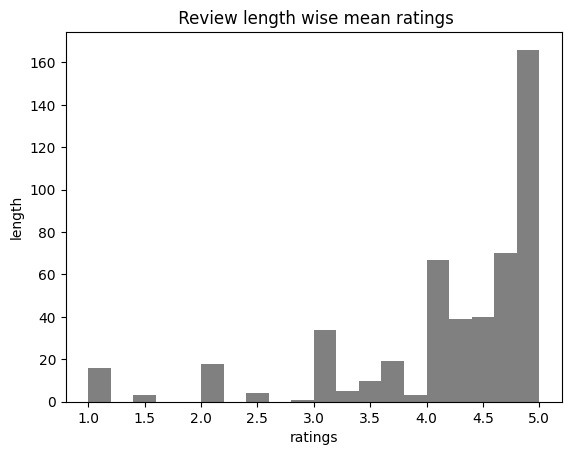

In [52]:
amazon_data.groupby('length')['rating'].mean().plot.hist(color='gray', bins = 20)
plt.title(" Review length wise mean ratings")
plt.xlabel('ratings')
plt.ylabel('length')
plt.show()

The average length is greater for positive feedback, indicating that detailed responses are more common when people are satisfied.

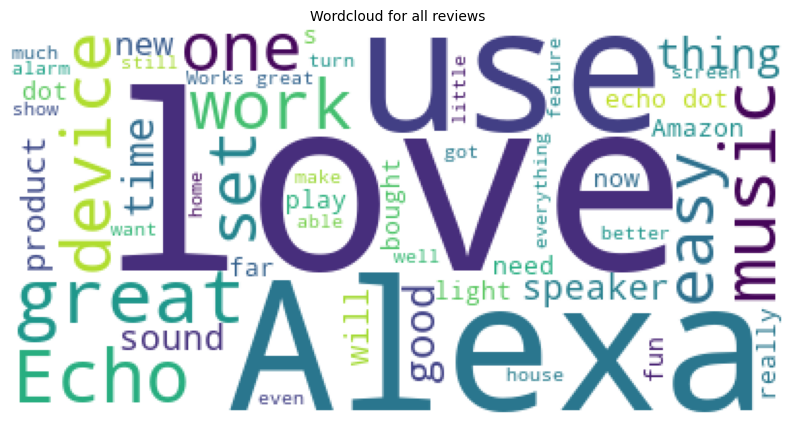

In [54]:
# Combine all reviews
reviews = " ".join([review for review in amazon_data['verified_reviews']])
                        
# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

__Finding the unique words in each feedback category__

In [56]:
# Combining all reviews for each feedback category and splitting them into individual words
negative_reviews = " ".join([review for review in amazon_data[amazon_data['feedback'] == 0]['verified_reviews']])
negative_reviews = negative_reviews.lower().split()

positive_reviews = " ".join([review for review in amazon_data[amazon_data['feedback'] == 1]['verified_reviews']])
positive_reviews = positive_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in negative_reviews if x not in positive_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in positive_reviews if x not in negative_reviews]
unique_positive = " ".join(unique_positive)

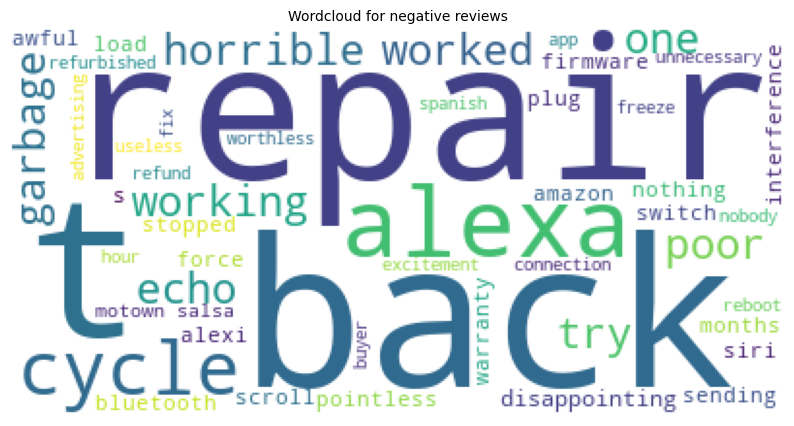

In [57]:
wc = WordCloud(background_color='white', max_words=50)

#Generating and plotting the wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

The word cloud above displays negative terms such as garbage, pointless, poor, horrible, and repair

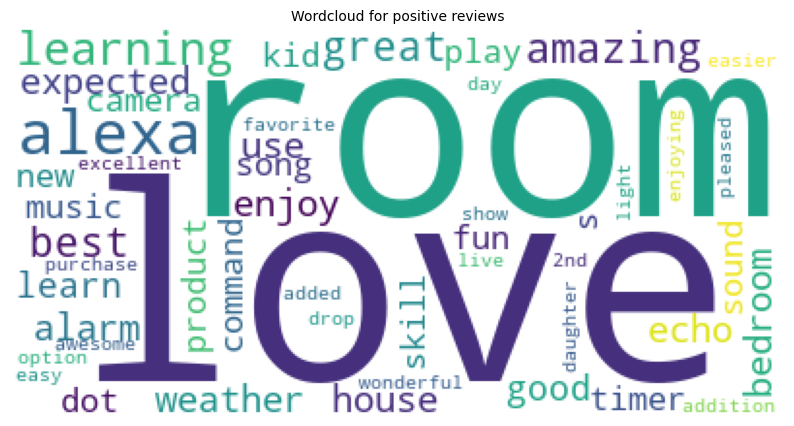

In [59]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

The word cloud above highlights positive words such as good, enjoying,best, love, excellent, easier

# Preprocessing and Modelling
To build the corpus from the 'verified_reviews' we perform the following 
- Replace any non alphabet characters with a space
- Covert to lower case and split into words
- Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus

In [62]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, amazon_data.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', amazon_data.iloc[i]['verified_reviews']) # replacing  any character that is not an alphabet letter (both lowercase and uppercase) with a space.
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

Using Count Vectorizer to create bag of words

In [64]:
cv = CountVectorizer(max_features = 2500)

#Storing independednt and depended variables in X and y
X = cv.fit_transform(corpus).toarray()
y = amazon_data['feedback'].values

In [65]:
#saving the count vectorizer
pickle.dump(cv,open('countVectorizer.pkl','wb'))

Checking the shape of X and y

In [67]:
X.shape, y.shape

((3149, 2500), (3149,))

Splitting data into train and test set with 30% data with testing

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 15)
print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (2204, 2500)
y train: (2204,)
X test: (945, 2500)
y test: (945,)


In [70]:
X_train.max() , X_test.max()

(np.int64(12), np.int64(10))

Scaling X_train and X_test so that all values are between 0 and 1

In [72]:
scaler = MinMaxScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)


In [73]:
#Saving the scaler model
pickle.dump(scaler, open('scaler.pkl','wb'))

#### Random Forest

In [75]:
#Fitting scaled X_train and y_train on Random Forest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scale, y_train)

RandomForestClassifier()

In [76]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_rf.score(X_train_scale, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scale, y_test))

Training Accuracy : 0.9941016333938294
Testing Accuracy : 0.944973544973545


In [77]:
#Predicting on the test set
y_preds = model_rf.predict(X_test_scale)

In [78]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)

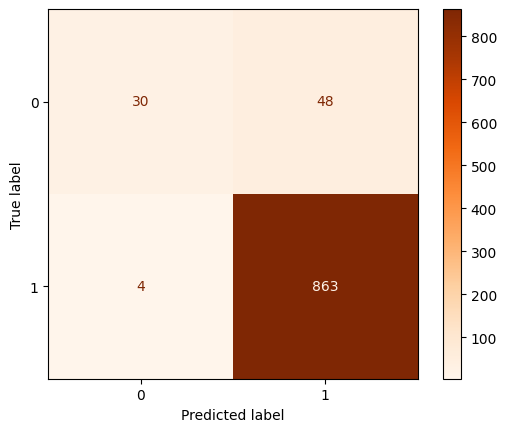

In [79]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
disp.plot(cmap = plt.cm.Oranges)
plt.show()

#### Decision Tree

In [81]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scale, y_train)

DecisionTreeClassifier()

In [82]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_dt.score(X_train_scale, y_train))
print("Testing Accuracy :", model_dt.score(X_test_scale, y_test))

Training Accuracy : 0.9941016333938294
Testing Accuracy : 0.9174603174603174


In [83]:
y_preds = model_dt.predict(X_test)

In [84]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)

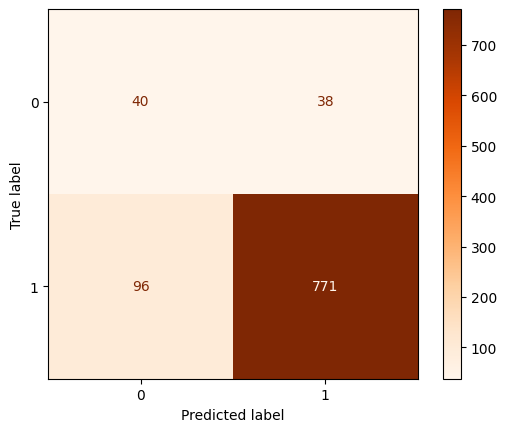

In [85]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_dt.classes_)
disp.plot(cmap = plt.cm.Oranges)
plt.show()

#### XGBoost

In [87]:
model_xg = XGBClassifier()
model_xg.fit(X_train_scale, y_train )

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [88]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_xg.score(X_train_scale, y_train))
print("Testing Accuracy :", model_xg.score(X_test_scale, y_test))

Training Accuracy : 0.971415607985481
Testing Accuracy : 0.9417989417989417


In [89]:
y_preds = model_xg.predict(X_test)

In [90]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)

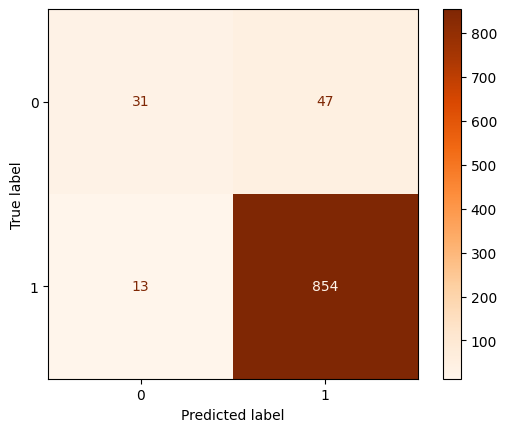

In [91]:
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model_xg.classes_ )
disp.plot(cmap = plt.cm.Oranges)
plt.show()

### Choosing Random Forest

I decided to use the Random Forest model because:

1. **Best Accuracy**: It has the highest testing accuracy (94.50%), meaning it performs best on new, unseen data.
2. **Less Overfitting**: Random Forest is more stable and less likely to overfit compared to a single Decision Tree.
3. **Good Performance**: It slightly outperforms XGBoost in this case and is easier to use.

Overall, Random Forest is the best option for this task.


In [93]:
#Saving the Random Forest classifier
pickle.dump(model_xg, open('model_xgb.pkl','wb'))